In [1]:
%%capture
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
import tensorflow as tf

2024-07-16 15:34:14.019779: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 15:34:19.934360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
##accessing a CSV for bug data
uploaded_zip = '/home/spope/EclipsePlatform/eclipse_platform.zip'
extract_dir = '/home/spope/EclipsePlatform/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(uploaded_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_file = os.path.join(extract_dir, 'eclipse_platform.csv')
fulldata = pd.read_csv(csv_file)

In [3]:
# Split the data into training and test sets
train_size = int(0.8 * len(fulldata))
test_size = len(fulldata) - train_size

trainset, testset = fulldata[:train_size], fulldata[train_size:]

In [4]:
#Creating a dataset to work with without messing up the initial one from the CSV
timedata = trainset

In [5]:
# Create a copy of the DataFrame to avoid SettingWithCopyWarning
timedata = timedata.copy()

# Ensure the 'Created_time' and 'Resolved_time' columns are in a consistent datetime format
timedata['Created_time'] = pd.to_datetime(timedata['Created_time'], utc=True)
timedata['Resolved_time'] = pd.to_datetime(timedata['Resolved_time'], utc=True)

# Convert to the desired format
timedata['Created_time2'] = timedata['Created_time'].dt.strftime('%m/%d/%Y %H:%M')
timedata['Resolved_time2'] = timedata['Resolved_time'].dt.strftime('%m/%d/%Y %H:%M')

# Parse the formatted datetime strings back to datetime objects to ensure they are in the correct format
timedata['Created_time2'] = pd.to_datetime(timedata['Created_time2'], format='%m/%d/%Y %H:%M')
timedata['Resolved_time2'] = pd.to_datetime(timedata['Resolved_time2'], format='%m/%d/%Y %H:%M')

# Calculate the duration in hours
timedata['Duration'] = timedata['Resolved_time2'] - timedata['Created_time2']
timedata['Duration_hours'] = timedata['Duration'].dt.total_seconds() / 3600

# Drop the intermediate columns
timedata.drop(['Created_time2', 'Resolved_time2', 'Duration'], axis=1, inplace=True)

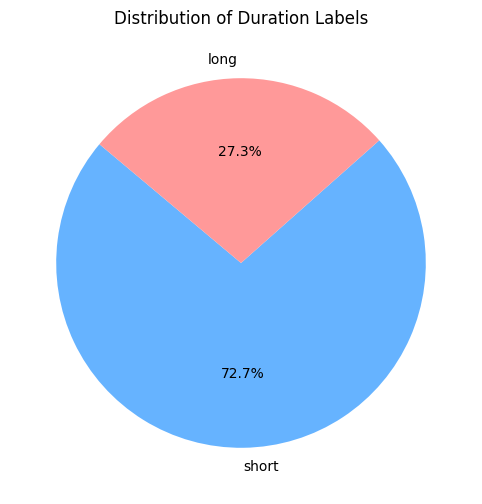

In [7]:
# Create a copy of the DataFrame to avoid SettingWithCopyWarning
timedata = timedata.copy()

# Find the mean duration in hours
mean_duration_hours = timedata['Duration_hours'].mean()

# Apply labels based on the mean duration
timedata.loc[:, 'TimeLabel'] = timedata['Duration_hours'].apply(lambda x: 'long' if x >= mean_duration_hours else 'short')

# Create a pie chart to show percentages of bugs that took a long time to fix and percentages that took a short time to fix
label_counts = timedata['TimeLabel'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ff9999'])
plt.title('Distribution of Duration Labels')
plt.show()

# Create a CSV that includes the duration
timedata.to_csv("timedata.csv", index=False)
preprocessing = pd.read_csv('timedata.csv')



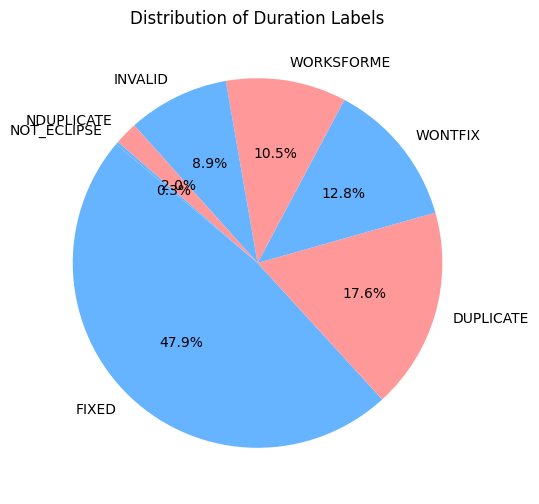

In [7]:
label_counts = timedata['Resolution'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ff9999'])
plt.title('Distribution of Duration Labels')
plt.show()

In [8]:
import zipfile
import os

def zip_csv_file(csv_filename, zip_filename):
    """
    Zip a CSV file.

    Parameters:
    - csv_filename: Name of the CSV file to zip.
    - zip_filename: Name of the output zip file.
    """
    # Create a ZipFile object
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Add the CSV file to the zip file
        zipf.write(csv_filename, os.path.basename(csv_filename))

zip_csv_file("timedata.csv", "timedata.zip")

In [9]:
%%capture
## imports for preprocessing
!pip install -U scikit-learn
!pip install nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('all')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [10]:
##removing stopwords

#making all the items in the descriptions columns lower
preprocessing['Description'] = preprocessing['Description'].str.lower()

# Define stop words
stop_words = set(stopwords.words('english'))

# Remove stop words from each description
for i in range(len(preprocessing)):
    words = preprocessing.loc[i, 'Description'].split()
    final_tokens = [word for word in words if word not in stop_words]
    preprocessing.at[i, 'Description'] = ' '.join(final_tokens)

In [11]:
##checking to see if stop words were removed by counting the amount of them in the columns

# Ensure 'Description' column is string type
preprocessing['Description'] = preprocessing['Description'].astype(str)

# Join all descriptions into a single string
all_descriptions = ' '.join(preprocessing['Description'].tolist())

# Tokenize the combined descriptions
words = nltk.word_tokenize(all_descriptions)
print("The number of tokens is", len(words))

# Split descriptions into sentences (assuming sentences are separated by full stops)
sents = nltk.sent_tokenize(all_descriptions)

# Calculate number of unique tokens
unique_tokens = set(words)
print("The number of unique tokens are", len(unique_tokens))

# Remove stopwords
stop_words = set(stopwords.words('english'))
final_tokens = [word for word in words if word.lower() not in stop_words]
print("The number of total tokens after removing stopwords are", len(final_tokens))


The number of tokens is 7888627
The number of unique tokens are 375003
The number of total tokens after removing stopwords are 7741345


In [12]:
## also checking to see if stop words were removed by counting the rows that include the word the

processed_df = preprocessing

# Convert 'description' column to string type
processed_df['Description'] = processed_df['Description'].astype(str)

keyword = 'the'
found_rows = processed_df['Description'].str.contains(keyword, case=False)
matching_rows = processed_df[found_rows]
len(matching_rows)

16976

In [13]:
##lemmatizing the descriptions

preprocessing = pd.DataFrame(preprocessing)

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence)
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Lemmatize verbs (default)
    return ' '.join(lemmatized_words)

# Apply lemmatization to each row in the 'descriptions' column
preprocessing['Description'] = preprocessing['Description'].apply(lemmatize_sentence)

In [14]:
%%capture
##performing sentiment analysis on the description column

sentiAnalysis = preprocessing
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

# Function to calculate sentiment scores
def calculate_sentiment_scores(description):
    tokens = word_tokenize(description)
    tagged_tokens = pos_tag(tokens)
    
    pos_score = 0
    neg_score = 0
    token_count = 0
    
    for word, tag in tagged_tokens:
        wn_tag = get_wordnet_pos(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            continue
        
        synsets = list(swn.senti_synsets(word, wn_tag))
        if not synsets:
            continue
        
        # Use the first synset for simplicity
        synset = synsets[0]
        pos_score += synset.pos_score()
        neg_score += synset.neg_score()
        token_count += 1
    
    # Normalize scores by the number of tokens
    if token_count > 0:
        pos_score /= token_count
        neg_score /= token_count
    
    return pos_score, neg_score

# Apply sentiment score calculation to each description
sentiAnalysis[['Pos_Score', 'Neg_Score']] = sentiAnalysis['Description'].apply(lambda x: pd.Series(calculate_sentiment_scores(x)))

# Display the DataFrame with the new columns
sentiAnalysis

In [15]:

##Creating a column for binary emotion (positive or negative)
sentiAnalysis['Emotion'] = sentiAnalysis['Pos_Score'] - sentiAnalysis['Neg_Score']

# Assign labels based on the difference
sentiAnalysis['Emotion'] = sentiAnalysis['Emotion'].apply(lambda x: 'positive' if x > 0 else 'negative')

In [16]:
##Creating a column for total emotionality (positive + negative)
sentiAnalysis['Emotionality'] = sentiAnalysis['Pos_Score']+ sentiAnalysis['Neg_Score']

In [19]:
def Destiny(df):
    # Create a new column 'Destiny' with default value 'Not Fixed'
    df['Destiny'] = 'Not Fixed'
    
    # Update 'Destiny' based on conditions in 'Resolution' column
    df.loc[df['Resolution'] == 'FIXED', 'Destiny'] = 'Fixed'
    return df
sentiAnalysis = Destiny(sentiAnalysis)

In [21]:
##saving to a CSV
sentiAnalysis.to_csv("sentiAnalysis.csv", index=False)
DFsentiAnalysis = pd.read_csv('sentiAnalysis.csv')
zip_csv_file("sentiAnalysis.csv", "sentiAnalysis.zip")

In [17]:
##installing stuff for word vectorization 
%%capture
!pip install gensim pandas
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

UsageError: Line magic function `%%capture` not found.


In [ ]:
##Vectorizing the descriptions
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

DFsentiAnalysis['tokenized_descriptions'] = DFsentiAnalysis['Description'].astype(str).fillna('')
model = Word2Vec(sentences=DFsentiAnalysis['tokenized_descriptions'], vector_size=100, window=5, min_count=1, workers=4)

model.save("word2vec.model")

# Example of using the model to find similar words
similar_words = model.wv.most_similar('annoying')
print(similar_words)

In [ ]:
##creating a coumn for the encoded labels of the vectors
max_length = max(DFsentiAnalysis['vectorized_descriptions'].apply(len))
X = pad_sequences(DFsentiAnalysis['vectorized_descriptions'], maxlen=max_length, dtype='float32', padding='post', value=0.0)
from sklearn.preprocessing import LabelEncoder

# Encode the labels
label_encoder = LabelEncoder()
DFsentiAnalysis['encoded_label'] = label_encoder.fit_transform(DFsentiAnalysis['label'])

# Prepare the labels
y = DFsentiAnalysis['encoded_label'].values

In [ ]:
##Importing for the MLP model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [170]:
##creating a column for column for if a bug is fixed or not fixed
def categorize_label(label):
    if 'FIXED' in label.upper():  # Convert to uppercase and check for 'FIXED'
        return 'FIXED'
    else:
        return 'NOTFIXED'

# Apply the function to create 'eventual_label' column
DFsentiAnalysis['eventual'] = DFsentiAnalysis['Resolution'].apply(categorize_label)
df2=DFsentiAnalysis

In [171]:
##Function for the MLP
def train_and_evaluate_model(df, input_columns, target_column, test_size=0.25, max_features=1000, hidden_layer_sizes=(64, 32), activation='relu', max_iter=100, random_state=42):
    """
    Train and evaluate a neural network model on the provided DataFrame.
    
    Parameters:
    - df: DataFrame containing the data.
    - input_columns: List of column names to be used as input features.
    - target_column: Name of the column to be used as the target variable.
    - test_size: Proportion of the dataset to include in the test split.
    - max_features: Maximum number of features for TF-IDF vectorization.
    - hidden_layer_sizes: The ith element represents the number of neurons in the ith hidden layer.
    - activation: Activation function for the hidden layer.
    - max_iter: Maximum number of iterations for training the neural network.
    - random_state: Seed used by the random number generator.
    
    Returns:
    - accuracy: Test accuracy of the trained model.
    """
    # Fill NaN values with a space
    
    df.fillna(' ', inplace=True)

    #checking if input is label to only look at the columns that say fixed
    if 'label' in target_column:
        df = df[df['Resolution'].str.contains('FIXED', na=False)]
        
    # Concatenate input columns to form the feature set
    X = df[input_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    y = df[target_column]  # Target variable

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Vectorize the text data
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Initialize and train the MLPClassifier
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, max_iter=max_iter, random_state=random_state)
    model.fit(X_train_vec, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_vec)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", accuracy)


In [176]:
##Testing for eventual label (FIXED or NOTFIXED) using priority and emotion: accuracy=.571
train_and_evaluate_model(df2, input_columns=['Priority', 'emotion'], target_column='eventual')

Test Accuracy: 0.5709588397627855


In [172]:
##Testing for eventual label (FIXED or NOTFIXED) using Description: accuracy=.588
train_and_evaluate_model(df2, input_columns=['Description'], target_column='eventual')

Test Accuracy: 0.5878691797310787


/home/spope/anaconda3/envs/reu/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [173]:
##Testing for eventual label (FIXED or NOTFIXED) using Description: accuracy=.571
train_and_evaluate_model(df2, input_columns=['Priority'], target_column='eventual')

Test Accuracy: 0.5709588397627855


In [174]:
##Testing for eventual label (FIXED or NOTFIXED) using Description: accuracy=.594
train_and_evaluate_model(df2, input_columns=['Priority', 'Description'], target_column='eventual')

Test Accuracy: 0.5935646761787329


/home/spope/anaconda3/envs/reu/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [175]:
##Testing for eventual label (FIXED or NOTFIXED) using Description: accuracy=.558
train_and_evaluate_model(df2, input_columns=['Priority', 'Emotionality'], target_column='eventual')

Test Accuracy: 0.5586283835359052


In [167]:
##Testing for label (Short or Long) using Priority and emotion: accuracy=.834
train_and_evaluate_model(df2, input_columns=['Priority','emotion'], target_column='label')

Test Accuracy: 0.8343753831065343


In [150]:
##Testing for label (Short or Long) using Priority and emotionality: accuracy=.827
train_and_evaluate_model(df2, input_columns=['Priority','Emotionality'], target_column='label')

Test Accuracy: 0.827264925830575


/home/spope/anaconda3/envs/reu/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [152]:
##Testing for label (Short or Long) using Description,emotionality, and emotion: accuracy=.774
train_and_evaluate_model(df2, input_columns=['Description','emotion', 'Emotionality'], target_column='label')

Test Accuracy: 0.7740590903518451


In [156]:
##Testing for label (Short or Long) using Description: accuracy=.772
train_and_evaluate_model(df2, input_columns=['Description'], target_column='label')

Test Accuracy: 0.7718523967144784


In [158]:
##Testing for label (Short or Long) using emotion: accuracy=.834
train_and_evaluate_model(df2, input_columns=['emotion'], target_column='label')

Test Accuracy: 0.8344979771974991


In [157]:
##Testing for label (Short or Long) using Emotionality: accuracy=.834
train_and_evaluate_model(df2, input_columns=['Emotionality'], target_column='label')

Test Accuracy: 0.8335172244697806
